In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import yfinance as yf

In [102]:
df = yf.download('BBAS3.SA', period = 'max')

[*********************100%***********************]  1 of 1 completed


In [103]:
df.drop(['Adj Close','Volume'], axis=1, inplace=True)

### Definindo o candle sinal

In [104]:
condition_1 = df["Low"] > df["Low"].shift(1)
condition_2 = df["Low"].shift(1) < df["Low"].shift(2)
df["signal"] = condition_1 & condition_2

df.head(10)

,Open,High,Low,Close,signal
Date,,,,,
2000-01-03,2.800000,2.853333,2.733333,2.733333,False
2000-01-04,2.733333,2.740000,2.603333,2.603333,False
2000-01-05,2.600000,2.633333,2.506666,2.630000,False
2000-01-06,2.630000,2.666666,2.600000,2.666666,True
2000-01-07,2.666666,2.666666,2.606666,2.606666,False
2000-01-10,2.730000,2.753333,2.666666,2.750000,False
2000-01-11,2.766666,2.853333,2.676666,2.713333,False
2000-01-12,2.733333,2.766666,2.683333,2.750000,False
2000-01-13,2.800000,2.833333,2.703333,2.703333,False


### Calculando o Éden dos Traders

In [105]:
df["mme8"] = df["Close"].ewm(span=8, min_periods=8).mean()
df["mme80"] = df["Close"].ewm(span=80, min_periods=80).mean()

df["eden"] = (df["mme8"] > df["mme8"].shift(1)) & (df["mme80"] > df["mme80"].shift(1)) & (df["mme8"] > df["mme80"])

df.dropna(inplace=True)

df.head()

,Open,High,Low,Close,signal,mme8,mme80,eden
Date,,,,,,,,
2000-04-21,1.866666,1.866666,1.866666,1.866666,False,1.888118,2.248697,False
2000-04-24,1.880000,1.930000,1.866666,1.866666,False,1.883351,2.237830,False
2000-04-25,1.933333,1.966666,1.870000,1.873333,False,1.881125,2.227501,False
2000-04-26,1.916666,1.916666,1.846666,1.900000,False,1.885319,2.218253,False
2000-04-27,1.833333,1.916666,1.833333,1.900000,False,1.888581,2.209299,False


### Definindo o preço de compra

In [106]:
condition_1 = df["signal"].shift(1) == True
condition_2 = df["eden"].shift(1) == True 
condition_3 = df["High"] > df["High"].shift(1)
tick = 0.01

df["buy_price"] = np.where(
    condition_1 & condition_2 & condition_3, 
    np.where(df["Open"] > df["High"].shift(1), df["Open"], df["High"].shift(1) + tick),
    np.nan
)

df.tail()

,Open,High,Low,Close,signal,mme8,mme80,eden,buy_price
Date,,,,,,,,,
2024-03-01,57.950001,58.360001,57.830002,57.919998,True,58.209028,55.104182,False,NaN
2024-03-04,58.020000,58.209999,57.470001,57.680000,False,58.091466,55.167782,False,NaN
2024-03-05,57.799999,58.369999,57.689999,58.080002,True,58.088919,55.239689,False,NaN
2024-03-06,58.220001,59.009998,58.099998,58.939999,False,58.278047,55.331054,True,NaN
2024-03-07,58.939999,59.110001,58.680000,58.700001,False,58.371815,55.414238,True,NaN


### Definindo o alvo

In [107]:
max_high = df["High"].rolling(3).max()
min_low = df["Low"].rolling(3).min()

amplitude = (max_high.shift(1) - min_low.shift(1))
entry = df["High"].shift(1)

df["target"] =  amplitude + entry

df.tail()

,Open,High,Low,Close,signal,mme8,mme80,eden,buy_price,target
Date,,,,,,,,,,
2024-03-01,57.950001,58.360001,57.830002,57.919998,True,58.209028,55.104182,False,NaN,60.359997
2024-03-04,58.020000,58.209999,57.470001,57.680000,False,58.091466,55.167782,False,NaN,59.799999
2024-03-05,57.799999,58.369999,57.689999,58.080002,True,58.088919,55.239689,False,NaN,59.659996
2024-03-06,58.220001,59.009998,58.099998,58.939999,False,58.278047,55.331054,True,NaN,59.269997
2024-03-07,58.939999,59.110001,58.680000,58.700001,False,58.371815,55.414238,True,NaN,60.549995


### Definindo o stop

In [108]:
df["stop"] = df["Low"].shift(2) - tick
df.tail()

,Open,High,Low,Close,signal,mme8,mme80,eden,buy_price,target,stop
Date,,,,,,,,,,,
2024-03-01,57.950001,58.360001,57.830002,57.919998,True,58.209028,55.104182,False,NaN,60.359997,58.400000
2024-03-04,58.020000,58.209999,57.470001,57.680000,False,58.091466,55.167782,False,NaN,59.799999,57.690001
2024-03-05,57.799999,58.369999,57.689999,58.080002,True,58.088919,55.239689,False,NaN,59.659996,57.820002
2024-03-06,58.220001,59.009998,58.099998,58.939999,False,58.278047,55.331054,True,NaN,59.269997,57.460001
2024-03-07,58.939999,59.110001,58.680000,58.700001,False,58.371815,55.414238,True,NaN,60.549995,57.679999


### Definindo o algoritmo para simular as operações


In [109]:
import math

# Create a function to round any number to the smalles multiple of 100
def round_down(x):
    return int(math.floor(x / 100.0)) * 100

def backtest_algorithm(
    df,
    capital_exposure,
    initial_capital):

    # List with the total capital after every operation
    total_capital = [initial_capital]

    # List with profits for every operation
    all_profits = [] 

    ongoing = False

    for i in range(0,len(df)):

        if ongoing == True:

            if (df["Open"][i] >= target) | (df["Open"][i] <= stop): 
                exit = df["Open"][i]

                profit = shares * (exit - entry)
                # Append profit to list and create a new entry with the capital
                # after the operation is complete
                all_profits += [profit]
                current_capital = total_capital[-1] # current capital is the last entry in the list
                total_capital += [current_capital + profit]

                ongoing = False

            elif df["Low"][i] <= stop: 
                exit = stop

                profit = shares * (exit - entry)
                # Append profit to list and create a new entry with the capital
                # after the operation is complete
                all_profits += [profit]
                current_capital = total_capital[-1] # current capital is the last entry in the list
                total_capital += [current_capital + profit]

                ongoing = False

            elif df["High"][i] >= target: 
                exit = target

                profit = shares * (exit - entry)
                # Append profit to list and create a new entry with the capital
                # after the operation is complete
                all_profits += [profit]
                current_capital = total_capital[-1] # current capital is the last entry in the list
                total_capital += [current_capital + profit]

                ongoing = False

        else:
            if ~(np.isnan(df["buy_price"][i])):
                entry = df["buy_price"][i]
                stop = df["stop"][i]
                
                if df["Low"][i] > stop: 
                    ongoing = True
                    risk = entry - stop
                    target = df["target"][i]
                    shares = round_down(capital_exposure / risk)

    return all_profits, total_capital

### Calculando a estatística e a curva de capital

In [110]:
def get_drawdown(data, column = "Close"):
    data["Max"] = data[column].cummax()
    data["Delta"] = data['Max'] - data[column]
    data["Drawdown"] = 100 * (data["Delta"] / data["Max"])
    max_drawdown = data["Drawdown"].max()
    return max_drawdown

In [118]:
def strategy_test(all_profits, total_capital):
    gains = sum(x >= 0 for x in all_profits)
    losses = sum(x < 0 for x in all_profits)
    num_operations = gains + losses
    pct_gains = 100 * (gains / num_operations)
    pct_losses = 100 - pct_gains
    total_profit = sum(all_profits)
    pct_profit = (total_profit / total_capital[0]) * 100
    
    # Compute drawdown
    total_capital = pd.DataFrame(data=total_capital, columns=["total_capital"])
    drawdown = get_drawdown(data=total_capital, column="total_capital")

    # Compute profit per operation
    profit_per_operation = pct_profit / num_operations

    # Expeceted Value
    all_positives = [x for x in all_profits if x >= 0]
    average_gain = sum(all_positives) / len(all_positives)

    all_negatives = [x for x in all_profits if x < 0]
    average_loss = sum(all_negatives) / len(all_negatives)

    num_operations = len(all_profits)
    pct_gains = (len(all_positives) / num_operations)
    pct_losses = 1 - pct_gains
    
    expected_value = (average_gain * pct_gains) + (average_loss * pct_losses)

    return {
        "total_profit": total_profit,
        "pct_profit": pct_profit,
        "pct_drawdown": drawdown,
        "num_operations": num_operations,
        "pct_profit_per_operation": profit_per_operation,
        "num_gains": gains ,
        "pct_gains": pct_gains,
        "num_losses": losses,
        "pct_losses": pct_losses, 
        "expected_value": expected_value
    }
def capital_plot(total_capital, all_profits):
  all_profits = [0] + all_profits # make sure both lists are the same size
  cap_evolution = pd.DataFrame({'Capital': total_capital, 'Profit': all_profits})
  plt.title("Curva de Capital")
  plt.xlabel("Total Operações")
  cap_evolution['Capital'].plot()

### Realizando o backtest

In [119]:
all_profits, total_capital = backtest_algorithm(
    df=df,
    capital_exposure=1000,
    initial_capital=100000)

In [120]:
statistics = strategy_test(all_profits, total_capital)
statistics = pd.DataFrame.from_dict(statistics, orient='index')
statistics.round(1)

,0
total_profit,42080.0
pct_profit,42.1
pct_drawdown,4.2
num_operations,204.0
pct_profit_per_operation,0.2
num_gains,118.0
pct_gains,0.6
num_losses,86.0
pct_losses,0.4
expected_value,206.3


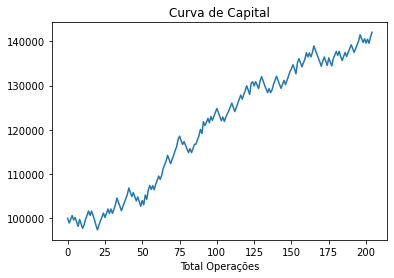

In [121]:
capital_plot(total_capital, all_profits)

### Calculando o valor esperado por operação

In [122]:
def expected_value(all_profits):
    all_positives = [x for x in all_profits if x >= 0]
    average_gain = sum(all_positives) / len(all_positives)

    all_negatives = [x for x in all_profits if x < 0]
    average_loss = sum(all_negatives) / len(all_negatives)

    num_operations = len(all_profits)
    pct_gains = (len(all_positives) / num_operations)
    pct_losses = 1 - pct_gains
    
    expected_value = (average_gain * pct_gains) + (average_loss * pct_losses)
    
    result = pd.DataFrame.from_dict({
        "average_gain": average_gain,
        "average_loss": average_loss,
        "pct_gains": pct_gains,
        "pct_losses": pct_losses,
        "expected_value": expected_value
    }, orient="index")
    result.columns = ["result"]
    return result

In [123]:
ev = round(expected_value(all_profits),2)
ev

,result
average_gain,1042.81
average_loss,-941.53
pct_gains,0.58
pct_losses,0.42
expected_value,206.27
